# PDZ3 Data Analysis for AIPD TEVV (Ikonomova et al.)

## Load raw data and merge with *in silico* metrics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy import stats
import os
import seaborn as sns

In [28]:
paraphrase = pd.read_csv("../data/selected_sequences.csv")
exp_data = pd.read_csv("../data/assay/pdz_all_results_df.csv")

exp_data_relevant = exp_data[exp_data['contents'] == "25.0 Sal; 50.0 Van; 12.5 TMP"]
exp_data_relevant = exp_data_relevant[exp_data_relevant['is_bad_rep'] == False]
exp_data_relevant = exp_data_relevant[exp_data_relevant['cript_number'] == 0]

# Rename variant identity column to match paraphrase
exp_data_relevant.rename(columns={'twist_name': 'selected_name'}, inplace=True)

## Labeling/Filtering
Significance testing with Welch's one-tailed t-tests. For this experiment, 'broken' = dead (no CRIPT sequence present)

In [29]:
def significance_test(df, a, labels, values, threshold=0.05):
    """
    Perform significance testing between a specified condition and all other conditions,
    distinguishing between conditions significantly greater than the reference.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    a : str
        The reference condition to compare against others
    labels : str
        Column name containing condition labels
    values : str
        Column name containing the measurement values
    threshold : float, default=0.05
        P-value threshold for determining significance
        
    Returns:
    --------
    pandas.DataFrame
        Summary dataframe with statistics and significance results including 'active' status
    """
    # Extract the reference condition data
    a_values = df[df[labels] == a][values].dropna().values
    a_mean = np.mean(a_values)
    
    # Get unique labels excluding the reference condition
    unique_labels = df[labels].unique()
    
    result_labels = []
    means = []
    sds = []
    p_values = []
    significants = []
    actives = []
    
    # Process each label
    for label in unique_labels:
        # Extract values for current label
        label_values = df[df[labels] == label][values].dropna().values
        
        # Calculate mean and standard deviation
        mean_value = np.mean(label_values)
        sd_value = np.std(label_values, ddof=1)  # Using sample standard deviation
        
        # Perform t-test if not comparing the condition to itself
        if label != a:
            # One-sided t-test to check if mean is greater than reference
            _, p_value = stats.ttest_ind(label_values, a_values, equal_var=False, alternative='greater')
        else:
            p_value = 1.0  # Same condition, so p-value is 1
        
        # Determine significance for two-sided test
        significant = p_value < threshold
        
        # Determine if the condition is significantly greater than reference (active)
        # Only mark as active if the one-sided test is significant
        active = p_value < threshold and mean_value > a_mean
        
        # Append results
        result_labels.append(label)
        means.append(mean_value)
        sds.append(sd_value)
        p_values.append(p_value)
        significants.append(significant)
        actives.append(active)
    
    # Create and return the summary dataframe
    summary_df = pd.DataFrame({
        'selected_name': result_labels,
        'mean_value': means,
        'sd_value': sds,
        'p_value': p_values,
        'significant': significants,
        'active': actives
    })
    
    return summary_df

In [30]:
# Apply the stats function
signif = significance_test(exp_data_relevant, 'broken', 'selected_name', 'p3_single_read', 0.05)

/usr/local/Caskroom/miniconda/base/envs/clip-search/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/Caskroom/miniconda/base/envs/clip-search/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/Caskroom/miniconda/base/envs/clip-search/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/Caskroom/miniconda/base/envs/clip-search/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


## Normalization and data export

In [31]:
# Background (nonbinding control) subtraction
nc = signif[signif['selected_name'] == 'broken']['mean_value'].mean()
signif['score'] = signif['mean_value'] - nc

# Normalization to wildtype
wt_mean = signif[signif['selected_name'] == 'WT']['score'].mean()
signif['score'] = signif['score'] / wt_mean

In [32]:
# Merge on variant names
merged = pd.merge(signif, paraphrase, on='selected_name', how='left')
merged.to_csv("../data/output/pdz_insilico_merged.csv", index=False)

## Plotting assay results

In [44]:
# Collect hits/plot
merged['significant_num'] = merged['significant'].astype(int)

df_plot = merged
df_plot = df_plot.dropna(subset=['dplddt_mean', 'tm_mean', 'seqid'])

df_plot = df_plot.sort_values(by='active')

shape_mapping = df_plot['active'].map({True: 'o', False: 'x'})
#edge_mapping = df_plot['active'].map({True: 'black', False: 'black'})

x, y, z = df_plot['dplddt_mean'], df_plot['tm_mean'], df_plot['seqid']

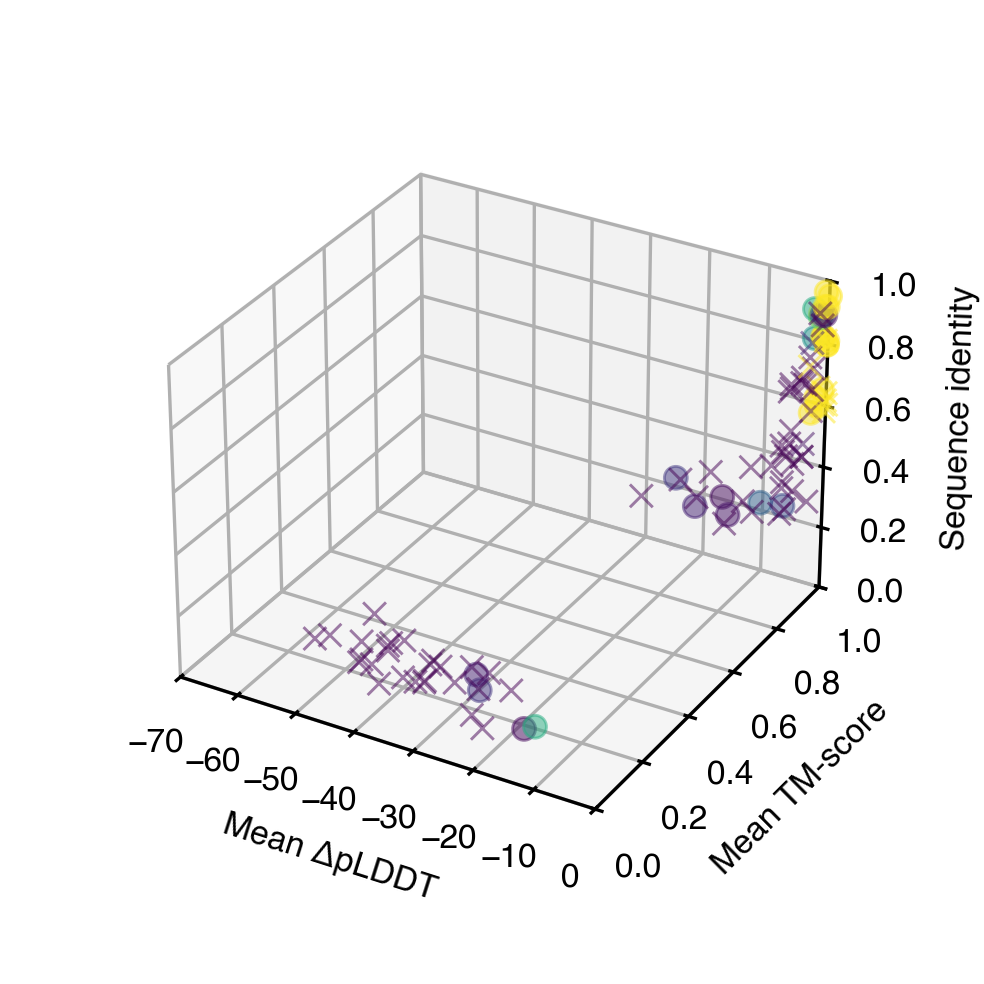

In [46]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
font = {'fontname':'Helvetica'}

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect(None, zoom=0.80)
ax.set_xlabel('Mean ΔpLDDT')
ax.set_xlim(-70, 0)
ax.set_ylabel('Mean TM-score')
ax.set_ylim(0, 1)
ax.set_zlabel('Sequence identity')
ax.set_zlim(0, 1)

# plot a 3D surface like in the example mplot3d/surface3d_demo
cmap = sns.color_palette("viridis", as_cmap=True)
# Clip color mapping to [0,1]
vmin = 0
vmax = 1
for shape in np.unique(shape_mapping):
    mask = shape_mapping == shape
    surf = ax.scatter(x[mask], y[mask], z[mask],
                    s=30,
                    alpha=0.5,
                    c=df_plot.loc[mask, 'score'],
                    marker=shape,
                    #edgecolors=edge_mapping[mask],
                    linewidths=0.7,
                    cmap=cmap,
                    vmin=vmin,
                    vmax=vmax,
                    )

ax.set_zlim(0, 1.0)
#fig.colorbar(surf, shrink=0.3, aspect=10)

# Get the current y and z limits
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

plt.show()

## BLAST Flagging

In [35]:
blast = pd.read_csv("../data/blast/psd95pdz3_blast_results.csv")
blast = pd.merge(blast, df_plot, left_on='query_sequence', right_on='selected_name')

In [36]:
### Flagger function

from Bio import Entrez

import requests
from bs4 import BeautifulSoup

# Function to fetch the metadata from the PDB landing page
def fetch_pdb_metadata_from_web(pdb_id):
    url = f"https://www.rcsb.org/structure/{pdb_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract the title of the structure
        title = soup.find('span', id='structureTitle').get_text(strip=True)
        
        # Extract the description/annotations (generally in the first paragraph or under a specific div)
        description_div = soup.find('div', class_='abstract')
        if description_div:
            description = description_div.get_text(strip=True)
        else:
            description = "No description available."
        
        return title, description
    else:
        print(f"Failed to fetch PDB {pdb_id}. HTTP Status: {response.status_code}")
        return None, None

def fetch_ncbi_record(query,
                      keyword_phrase="pdz",
                      email="geoffrey.taghon@nist.gov"):
    """
    Fetch an NCBI record using an accession number, regardless of database source.
    
    Parameters:
    query (str): The database and accession number (e.g., 'nucleotide|NM_123456')
    keyword_phrase (str): The phrase to search for (e.g., 'rna polymerase')
    email (str): Your email address for NCBI API access
    
    Returns:
    Boolean: True if all keywords in the phrase are found in the record, False otherwise
    """
    Entrez.email = email

    # If no top match, no flag
    if pd.isna(query):
        return False
    else:
        database, accession = str(query).split("|")[0], str(query).split("|")[1]
    
    # Convert keyword phrase to lowercase and split into individual keywords
    keywords = keyword_phrase.lower().split()
    
    # If PDB hit, handle differently
    if database == "pdb":
        title, description = fetch_pdb_metadata_from_web(accession)
        # Convert title to lowercase for case-insensitive search
        agg_info = title + description
        agg_info = agg_info.lower()
        # Check if all keywords are in the title
        if all(keyword in agg_info for keyword in keywords):
            return True
    
    # First, try to get the record from nucleotide database (covers most types)
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="xml", retmode="xml")
        record = handle.read()  # This returns bytes
        handle.close()
        # Convert bytes to string and make lowercase
        record_str = str(record).lower()
        if all(keyword in record_str for keyword in keywords):
            return True
    except Exception as e:
        print(f"Couldn't fetch from nucleotide database: {e}")
    
    # If that fails, try the protein database
    try:
        handle = Entrez.efetch(db="protein", id=accession, rettype="xml", retmode="xml")
        record = handle.read()  # This returns bytes
        handle.close()
        # Convert bytes to string and make lowercase
        record_str = str(record).lower()
        if all(keyword in record_str for keyword in keywords):
            return True
    except Exception as e:
        print(f"Couldn't fetch from protein database: {e}")
    
    # If both fail, try to search for the accession across databases
    try:
        # Use esearch to find which database the accession belongs to
        search_handle = Entrez.esearch(term=accession, retmax=1)
        search_results = Entrez.read(search_handle)
        search_handle.close()
        
        if search_results["Count"] != "0":
            record_id = search_results["IdList"][0]
            # Try to fetch using the found ID
            handle = Entrez.efetch(id=record_id, rettype="xml", retmode="xml")
            record = handle.read()  # This returns bytes
            handle.close()
            # Convert bytes to string and make lowercase
            record_str = str(record).lower()
            if all(keyword in record_str for keyword in keywords):
                return True
    except Exception as e:
        print(f"Couldn't find the accession in any database: {e}")
    
    return False

# If not already run, run BLAST flagger
if not os.path.exists('../data/output/pdz_blast_flags.csv'):
    blast['flagged'] = blast['top_match'].apply(fetch_ncbi_record)
    blast.to_csv("pdz_blast_flags.csv")

## Plotting BLAST confusion matrix

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def plot_confusion_matrix(y_true, y_pred, figsize=(4, 5), cmap='Blues', title='PDZ3'):
    """
    Create a visually appealing confusion matrix plot from two boolean series.
    
    Parameters:
    y_true (pd.Series or array-like): Series of actual values (TRUE/FALSE)
    y_pred (pd.Series or array-like): Series of predicted values (TRUE/FALSE)
    figsize (tuple): Figure size as (width, height)
    cmap (str): Colormap for the heatmap
    title (str): Title for the plot
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Ensure inputs are boolean
    y_true = pd.Series(y_true).astype(bool)
    y_pred = pd.Series(y_pred).astype(bool)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap=cmap,
        vmin=0,
        vmax=len(blast),
        linewidths=.5,
        square=True,
        cbar=False,
        annot_kws={"size": 32},
        ax=ax
    )
    
    # Labels, title and ticks
    ax.set_xlabel('Flagged by BLAST', fontsize=14, labelpad=10)
    ax.set_ylabel('Above threshold', fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=16, pad=20)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    # Set custom x and y tick labels
    ax.set_xticklabels(['–', '+'], fontsize=22)
    ax.set_yticklabels(['–', '+'], fontsize=22, rotation=0)
    
    # Add text annotations for the cells with descriptive labels
    categories = ['True negative', 'False positive', 'False negative', 'True positive']
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    for i, (pos_y, pos_x) in enumerate(positions):
        ax.text(
            pos_x + 0.5, 
            pos_y + 0.85, 
            categories[i],
            horizontalalignment='center',
            size=14,
            color='black' if cm[pos_y, pos_x] < (len(blast) / 2) else 'white'
        )
    
    # Add metrics as text below the matrix
    """
    plt.figtext(0.5, 0.01, 
                f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}',
                ha="center", 
                fontsize=12, 
                bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    """
    
    plt.tight_layout()

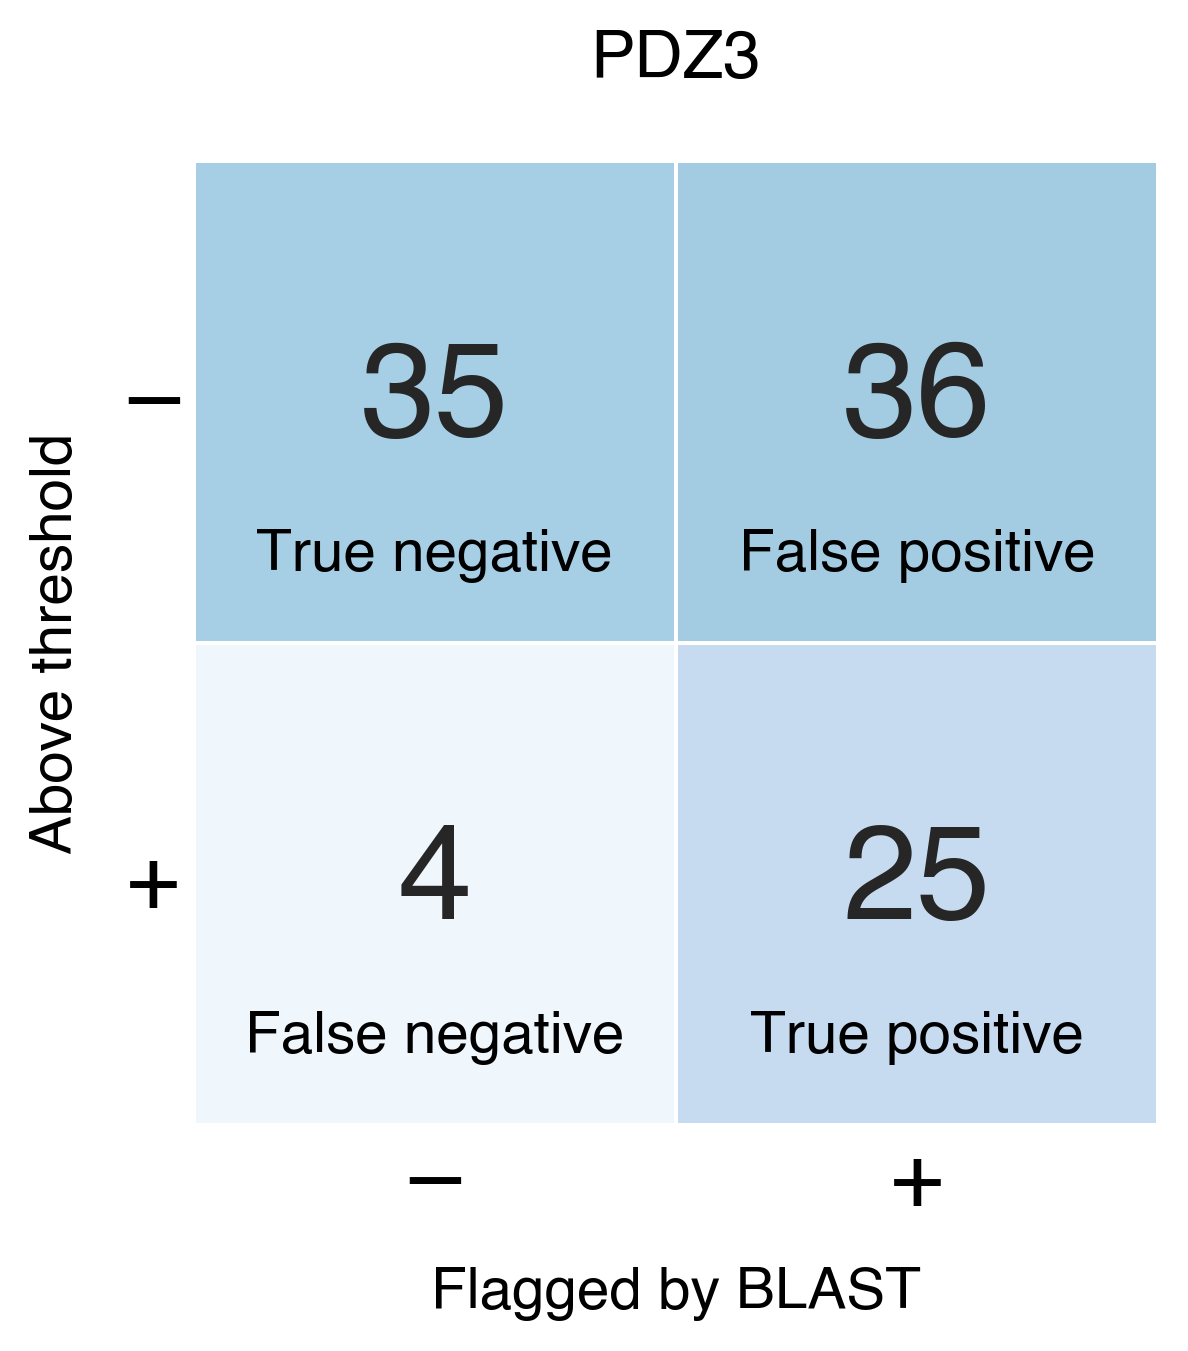

In [38]:
blast = pd.read_csv('../data/output/pdz_blast_flags.csv')

plot_confusion_matrix(blast['active'], blast['flagged'])

## Plotting metric corner plots

In [ ]:
def create_corner_plot(df, columns, hue=None, diag_kind='kde', plot_kwargs=None, diag_kwargs=None, 
                       show_metrics=True):
    """
    Create a corner plot (pair plot) for specified columns in a pandas DataFrame with correlation metrics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    columns : list
        List of column names to include in the plot.
    hue : str, optional
        Column name to use for coloring the points.
    diag_kind : {'hist', 'kde'}, default='kde'
        Type of plot to use for the diagonal subplots.
    plot_kwargs : dict, optional
        Additional keyword arguments for the scatter plots.
    diag_kwargs : dict, optional
        Additional keyword arguments for the diagonal plots.
    show_metrics : bool, default=True
        Whether to show correlation metrics (R² and RMSE) on each plot.
    
    Returns:
    --------
    g : seaborn.PairGrid
        The resulting corner plot.
    """
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.linear_model import LinearRegression
    
    # Set default kwargs if not provided
    if plot_kwargs is None:
        plot_kwargs = {'alpha': 0.6, 's': 30}
    if diag_kwargs is None:
        diag_kwargs = {'fill': True, 'alpha': 0.6}
    
    # Create the pair plot
    g = sns.pairplot(
        df[columns], 
        hue=hue,
        diag_kind=diag_kind,
        plot_kws=plot_kwargs,
        diag_kws=diag_kwargs,
        corner=True  # This makes it a corner plot
    )
    
    # Add correlation metrics to each plot
    if show_metrics:
        # Force plt.show() to render the plot before adding annotations
        plt.draw()
        
        for i, y_var in enumerate(columns[1:], 1):
            for j, x_var in enumerate(columns[:i]):
                ax = g.axes[i, j]
                
                # Get data for the current plot
                x = df[x_var].values
                y = df[y_var].values
                
                # Skip if there are NaN values
                mask = ~(np.isnan(x) | np.isnan(y))
                if not np.any(mask):
                    continue
                
                # Apply mask to remove NaNs
                x_clean = x[mask].reshape(-1, 1)
                y_clean = y[mask]
                
                # Fit a linear model
                model = LinearRegression()
                model.fit(x_clean, y_clean)
                
                # Predict using the model
                y_pred = model.predict(x_clean)
                
                # Calculate metrics
                r2 = r2_score(y_clean, y_pred)
                rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
                
                # Add metrics text to the plot - ensure it's visible
                metrics_text = f"$R^2$: {r2:.2f}\nRMSE: {rmse:.2f}"
                text_box = ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
                          verticalalignment='top', 
                          bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 0.2, 'boxstyle': 'round'},
                          zorder=1000)  # Ensure high z-order to be on top
                
                # Calculate x range for the regression line
                x_min = np.min(x_clean)
                x_max = np.max(x_clean)
                x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
                y_range = model.predict(x_range)
                
                # Add regression line with high zorder to ensure visibility
                line, = ax.plot(x_range, y_range, color='red', linestyle='--', linewidth=2, zorder=999)
                
                # Debug: print to confirm this code is running
                print(f"Added metrics for {x_var} vs {y_var}: R²={r2:.2f}, RMSE={rmse:.2f}")
    
    # Add a title
    g.fig.suptitle('PDZ3 homologs - metric correlations (linear)', y=1.02)
    
    # Adjust layout to ensure no clipping
    plt.tight_layout()
    
    return g

def exp_func(x, a, b):
    return a * np.exp(b * x)

def create_corner_plot_spearman(df, columns, hue=None, diag_kind='kde', plot_kwargs=None, diag_kwargs=None, 
                       show_metrics=True):
    """
    Create a corner plot (pair plot) for specified columns in a pandas DataFrame with Spearman correlation metrics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    columns : list
        List of column names to include in the plot.
    hue : str, optional
        Column name to use for coloring the points.
    diag_kind : {'hist', 'kde'}, default='kde'
        Type of plot to use for the diagonal subplots.
    plot_kwargs : dict, optional
        Additional keyword arguments for the scatter plots.
    diag_kwargs : dict, optional
        Additional keyword arguments for the diagonal plots.
    show_metrics : bool, default=True
        Whether to show Spearman correlation metrics on each plot.
    
    Returns:
    --------
    g : seaborn.PairGrid
        The resulting corner plot.
    """
    from scipy.stats import spearmanr
    from scipy.optimize import curve_fit
    
    # Set default kwargs if not provided
    if plot_kwargs is None:
        plot_kwargs = {'alpha': 0.6, 's': 30}
    if diag_kwargs is None:
        diag_kwargs = {'fill': True, 'alpha': 0.6}
    
    # Create the pair plot
    g = sns.pairplot(
        df[columns], 
        hue=hue,
        diag_kind=diag_kind,
        plot_kws=plot_kwargs,
        diag_kws=diag_kwargs,
        corner=True  # This makes it a corner plot
    )
    
    # Add correlation metrics to each plot
    if show_metrics:
        # Force plt.show() to render the plot before adding annotations
        plt.draw()
        
        for i, y_var in enumerate(columns[1:], 1):
            for j, x_var in enumerate(columns[:i]):
                ax = g.axes[i, j]
                
                # Get data for the current plot
                x = df[x_var].values
                y = df[y_var].values
                
                # Skip if there are NaN values
                mask = ~(np.isnan(x) | np.isnan(y))
                if not np.any(mask):
                    continue
                
                # Apply mask to remove NaNs
                x_clean = x[mask]
                y_clean = y[mask]
                
                # Calculate Spearman correlation
                rho, p_value = spearmanr(x_clean, y_clean)
                
                # Add metrics text to the plot - ensure it's visible
                metrics_text = f"ρ: {rho:.2f}\np: {p_value:.3f}"
                text_box = ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
                          verticalalignment='top', 
                          bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 0.2, 'boxstyle': 'round'},
                          zorder=1000)  # Ensure high z-order to be on top
                
                # Optional: Add a smoothed line to represent the relationship
                # (not a straight line since we're using rank correlation)
                try:
                    # Sort the data for the smoothed line
                    sorted_indices = np.argsort(x_clean)
                    x_sorted = x_clean[sorted_indices]
                    y_sorted = y_clean[sorted_indices]
                    
                    # Initial guess for parameters
                    p0 = [1, 0.1]  # initial values for a and b

                    # Perform non-linear least squares fit
                    popt, pcov = curve_fit(exp_func, x_sorted, y_sorted, p0=p0)

                    # Generate x values for the fitted line
                    x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 300)

                    # Calculate corresponding y values using the fitted parameters
                    y_smooth = exp_func(x_smooth, *popt)

                    # Add fitted exponential line to the plot
                    ax.plot(x_smooth, y_smooth, 'r-', alpha=0.5, zorder=999)
                except Exception as e:
                    print(f"Error: {e}")
                    pass
                
                # Debug: print to confirm this code is running
                print(f"Added Spearman metrics for {x_var} vs {y_var}: ρ={rho:.2f}, p={p_value:.3f}")
    
    # Add a title
    g.fig.suptitle('PDZ3 homologs - metric correlations (Spearman)', y=1.02)
    
    # Adjust layout to ensure no clipping
    plt.tight_layout()
    
    return g

Added metrics for dplddt_mean vs tm_mean: R²=0.79, RMSE=0.16
Added metrics for dplddt_mean vs seqid: R²=0.68, RMSE=0.17
Added metrics for tm_mean vs seqid: R²=0.64, RMSE=0.18
Added metrics for dplddt_mean vs active: R²=0.09, RMSE=0.43
Added metrics for tm_mean vs active: R²=0.05, RMSE=0.44
Added metrics for seqid vs active: R²=0.14, RMSE=0.42
Added Spearman metrics for dplddt_mean vs tm_mean: ρ=0.92, p=0.000
Added Spearman metrics for dplddt_mean vs seqid: ρ=0.89, p=0.000
Added Spearman metrics for tm_mean vs seqid: ρ=0.93, p=0.000
Added Spearman metrics for dplddt_mean vs active: ρ=0.37, p=0.000
Added Spearman metrics for tm_mean vs active: ρ=0.35, p=0.000
Added Spearman metrics for seqid vs active: ρ=0.35, p=0.000


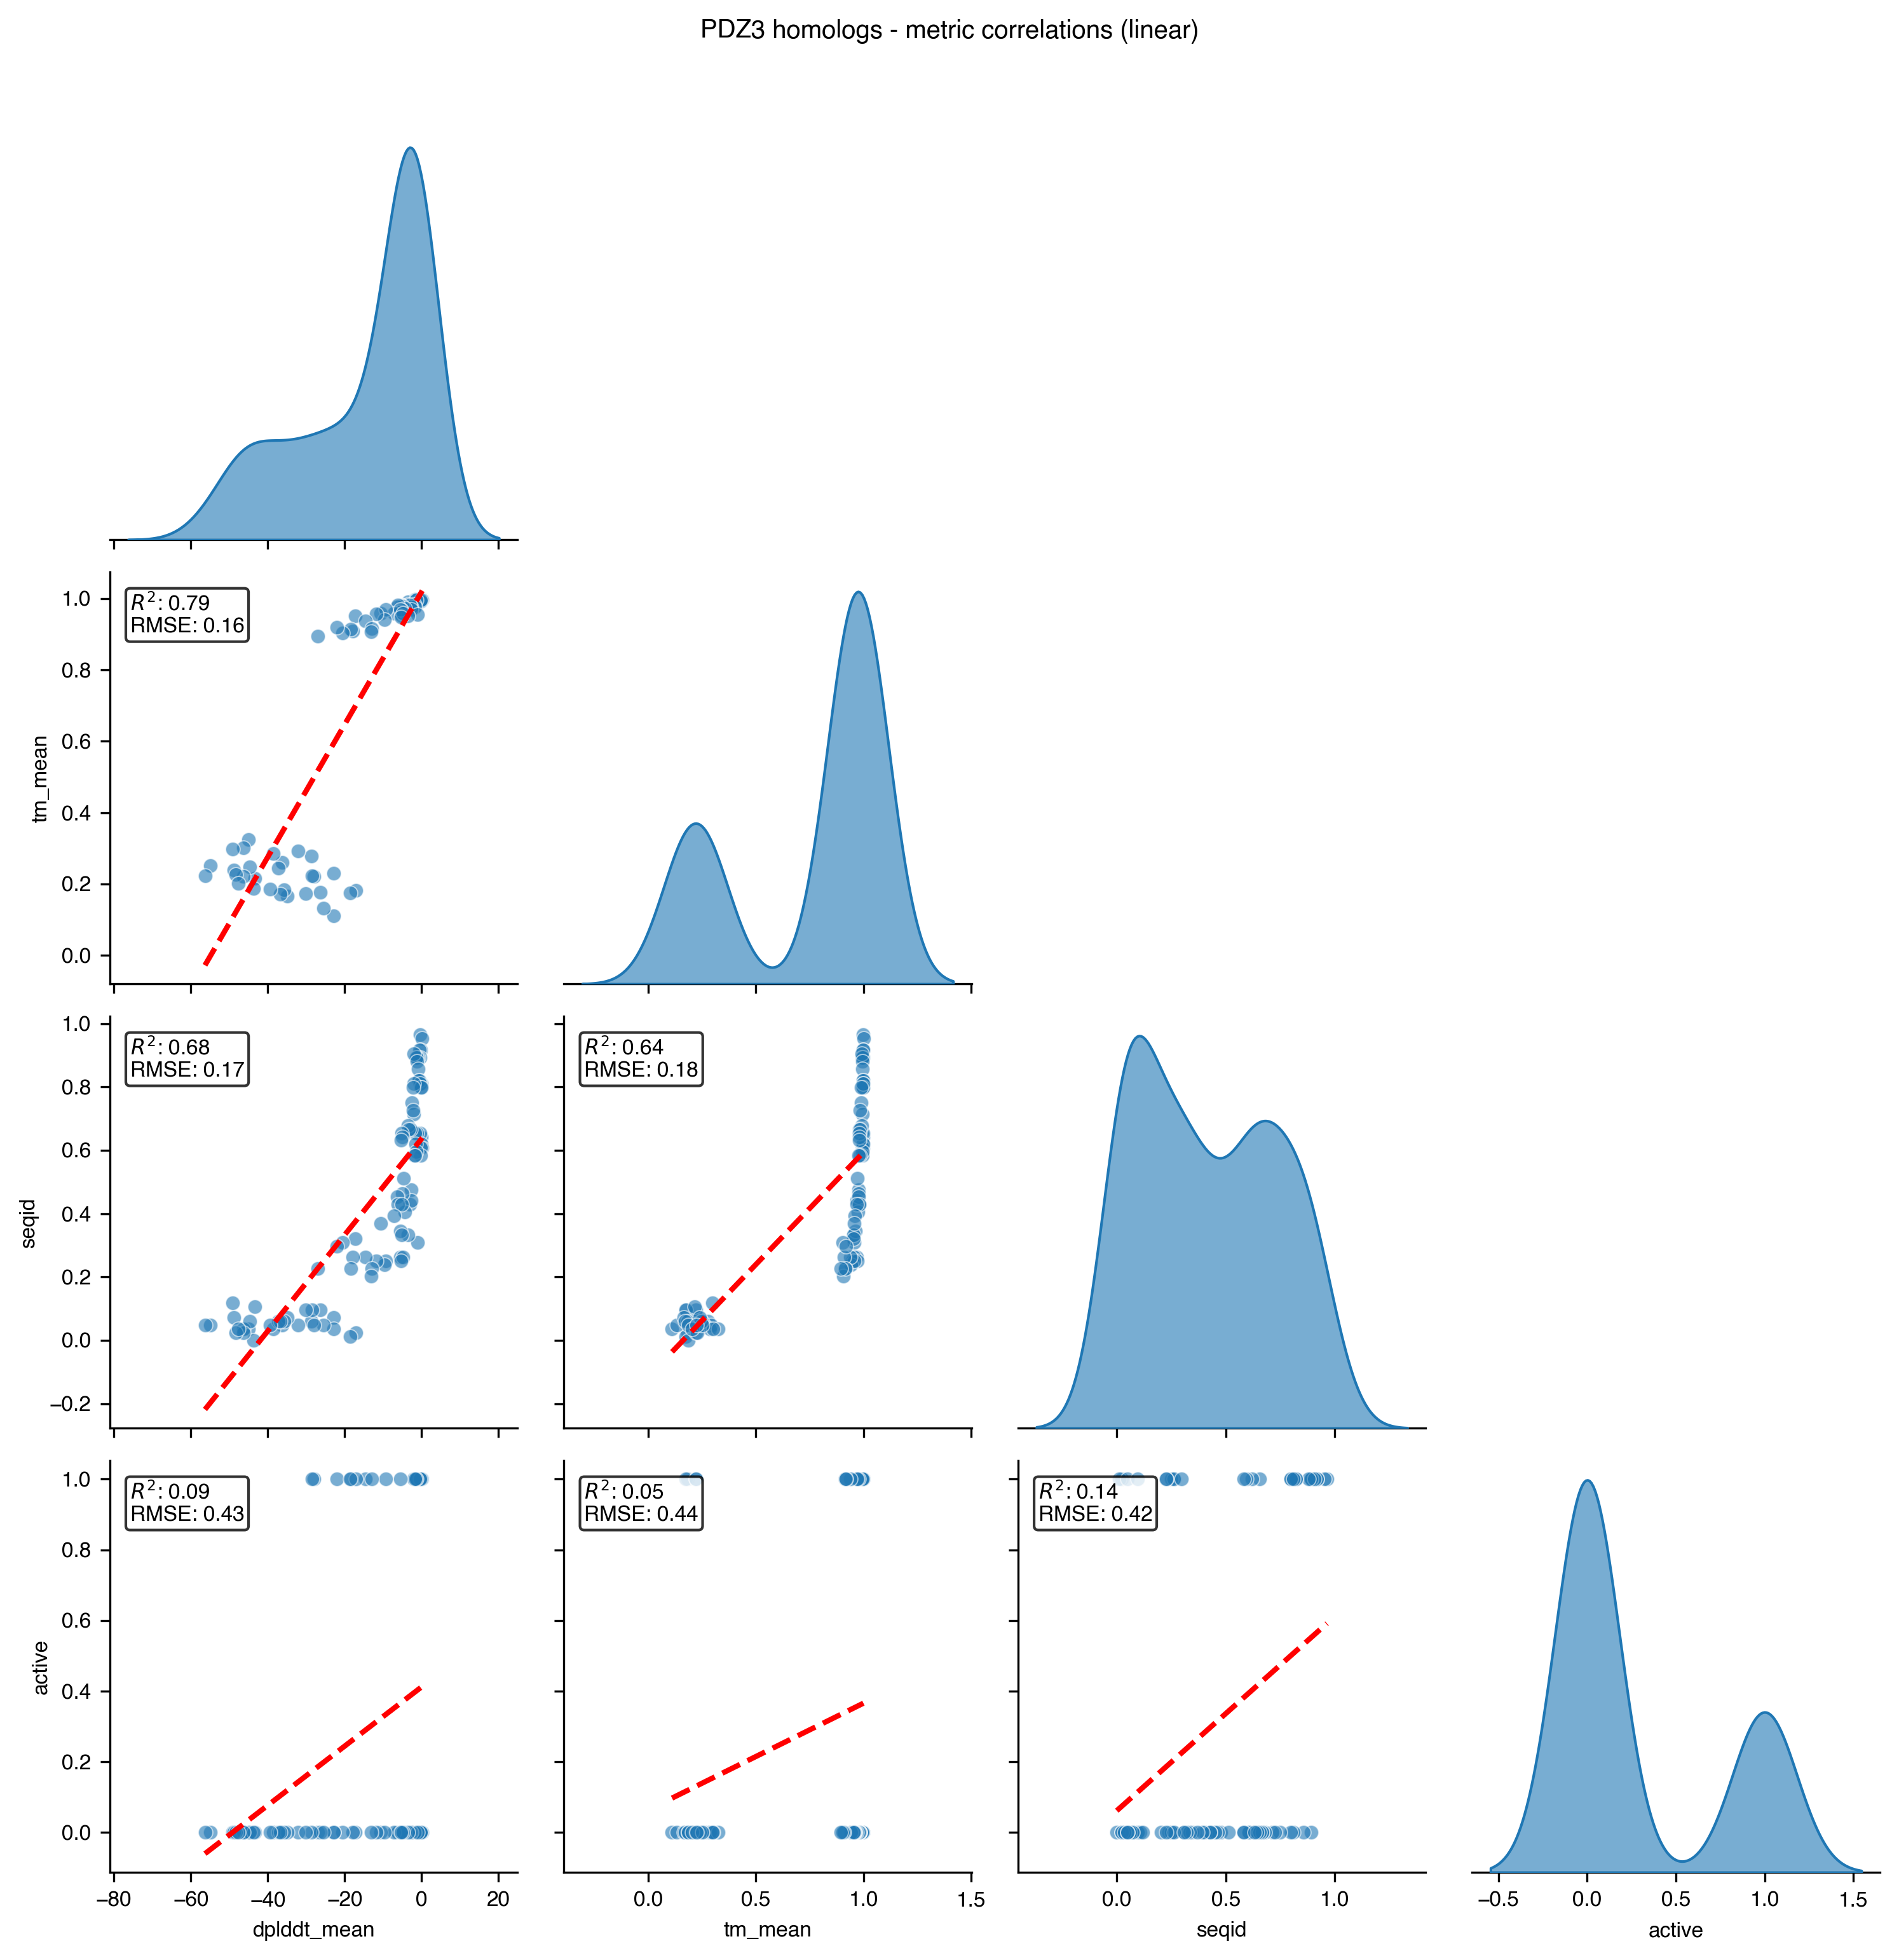

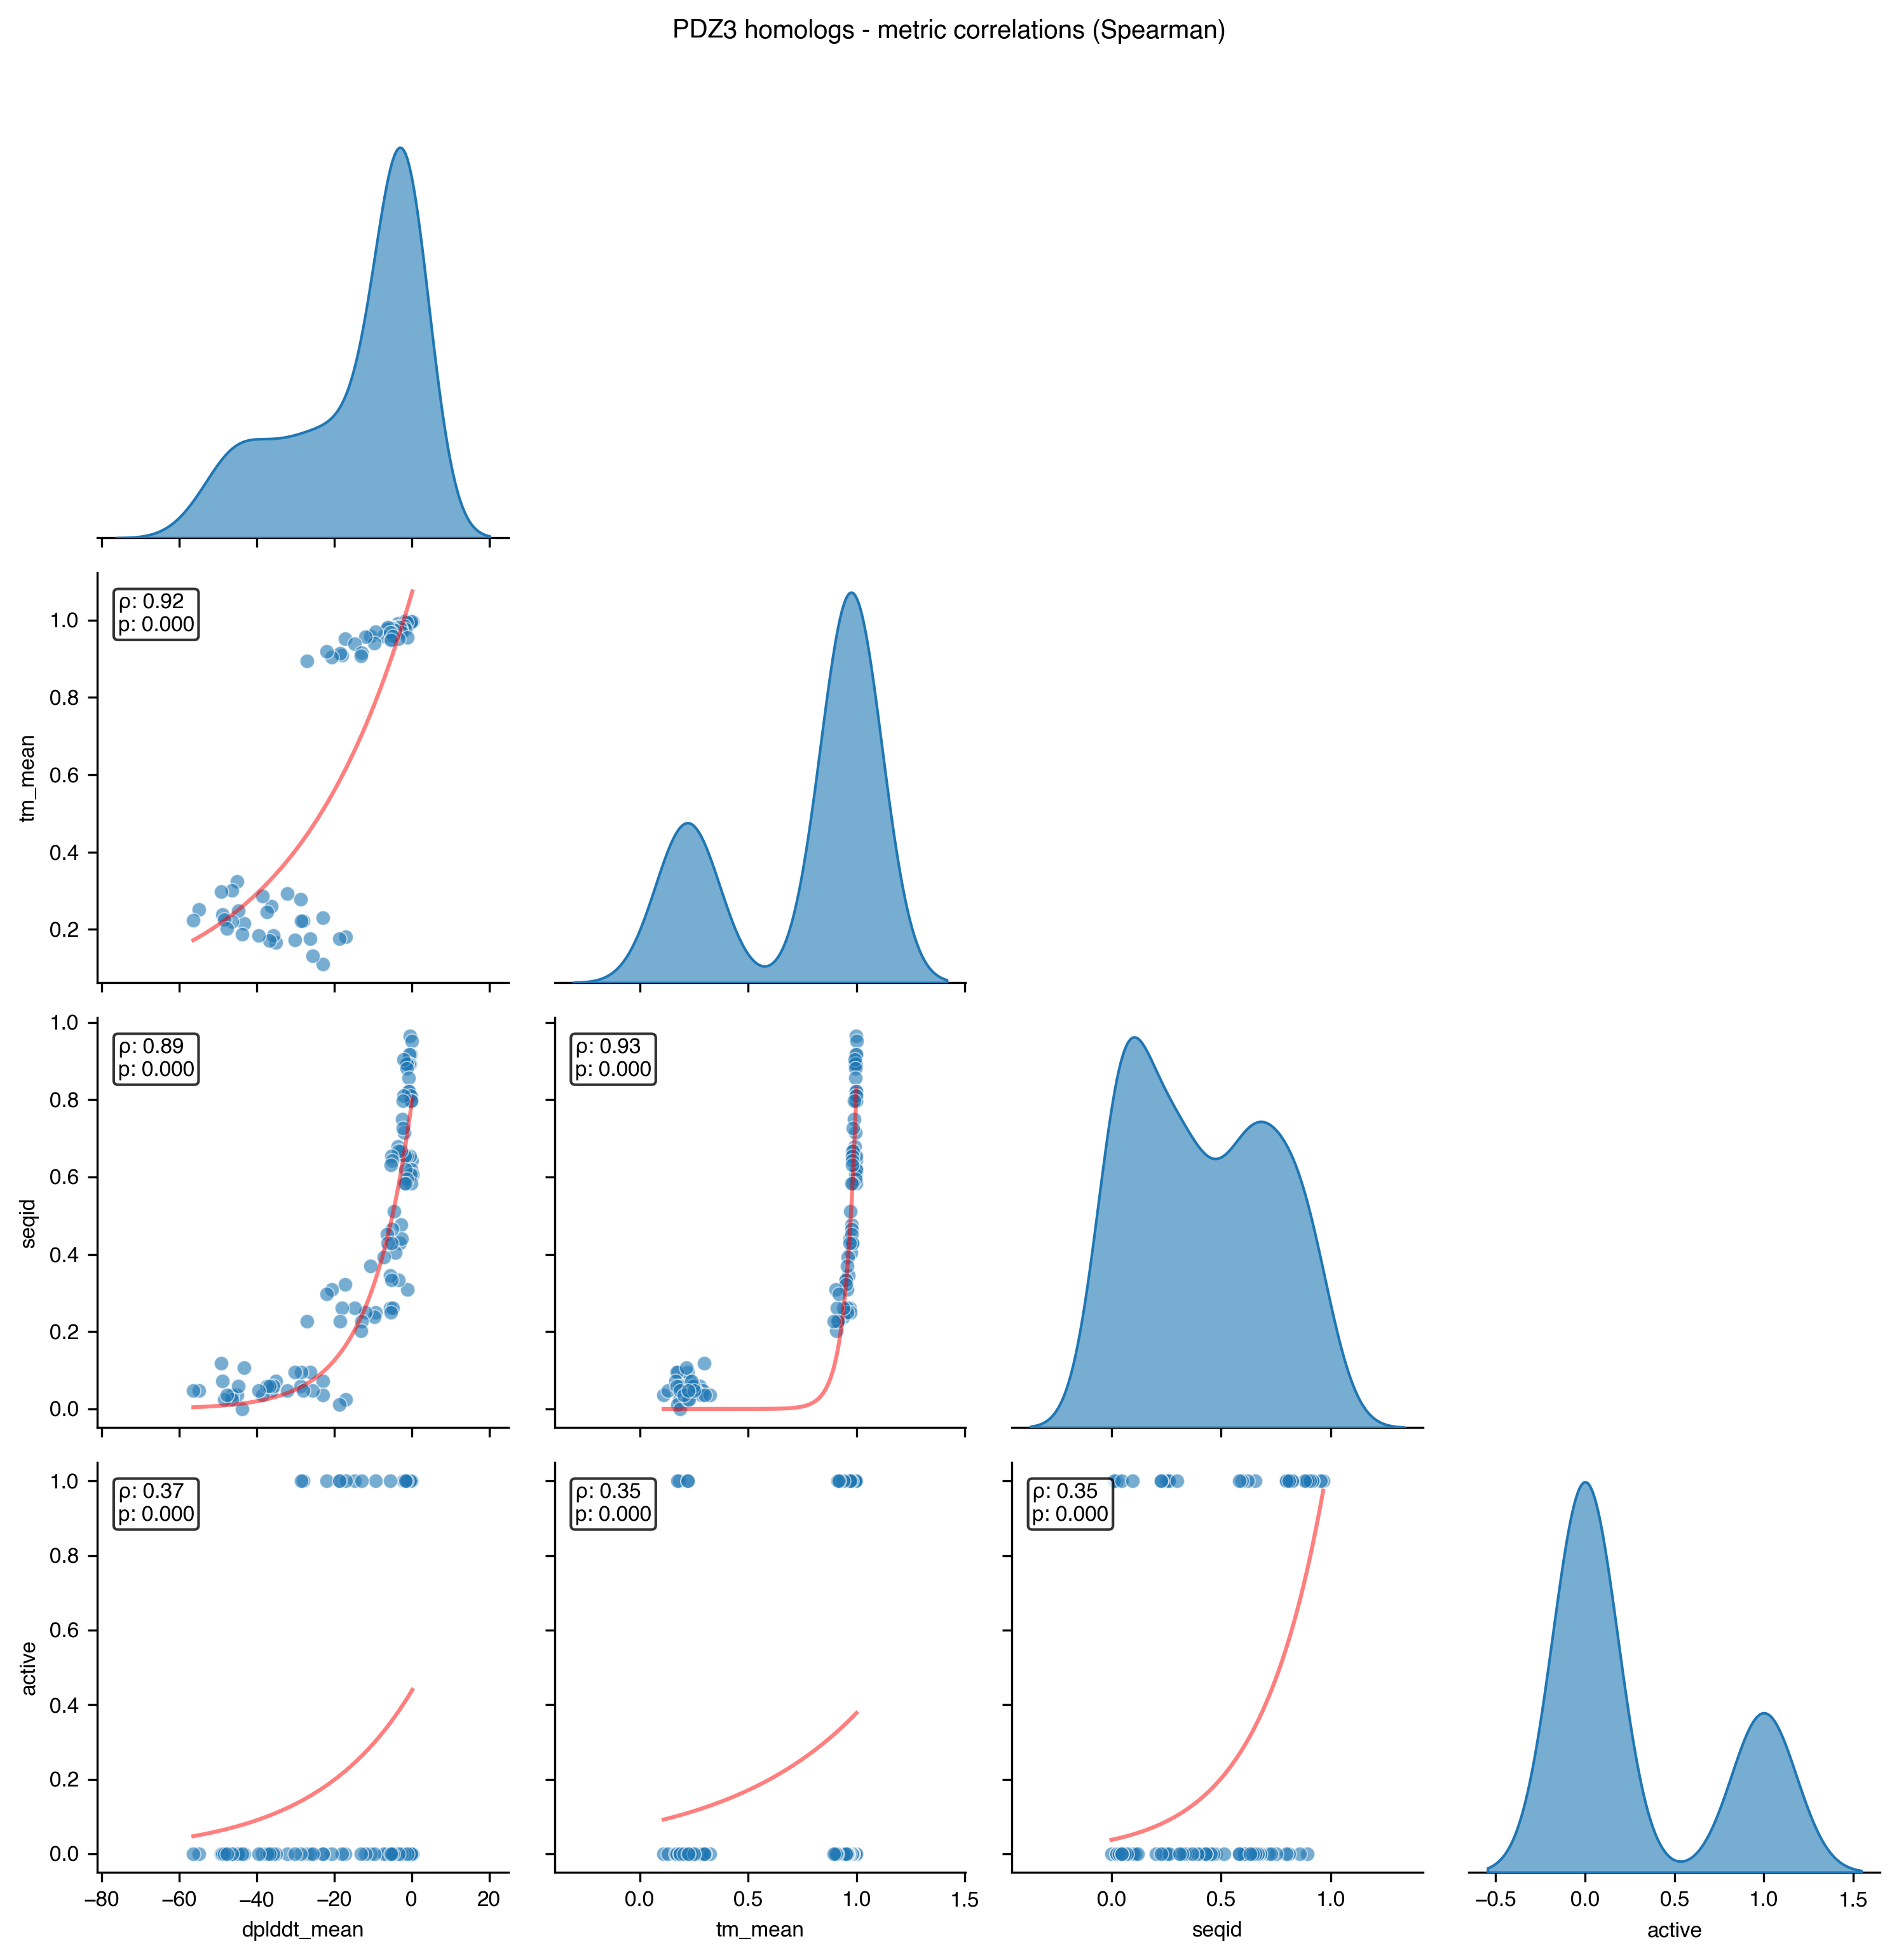

In [40]:
cols = ['dplddt_mean', 'tm_mean', 'seqid', 'active']
g = create_corner_plot(blast, cols, show_metrics=True, hue=None)
h = create_corner_plot_spearman(blast, cols, show_metrics=True, hue=None)

## AUROC Analysis

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns

def plot_corner_auroc(df, predictor_cols, label_col, figsize=(10, 10), color_map='viridis'):
    """
    Creates a corner AUROC plot for multiple predictors against a binary label column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    predictor_cols : list
        List of column names to use as predictors
    label_col : str
        Column name of the binary target variable (0/1 or False/True)
    figsize : tuple, optional
        Figure size as (width, height) in inches
    color_map : str, optional
        Colormap to use for the curves
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The corner plot figure
    auc_values : dict
        Dictionary with predictor column names as keys and AUC values as values
    """
    # Convert label column to numeric if it's not already
    y_true = df[label_col].astype(int)
    
    # Number of predictors
    n_predictors = len(predictor_cols)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set up colors
    colors = plt.get_cmap(color_map, n_predictors)
    
    # Store AUC values
    auc_values = {}
    
    label_key = {'dplddt_mean': "Mean ΔpLDDT", 'tm_mean': "Mean TM-score", 'seqid': "Sequence identity"}

    # Plot ROC curve for each predictor
    for i, col in enumerate(predictor_cols):
        # Get predictor values
        y_score = df[col].values
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        # Calculate AUC
        roc_auc = auc(fpr, tpr)
        auc_values[col] = roc_auc
        
        # Plot ROC curve
        ax.plot(fpr, tpr, lw=2, color=colors(i),
                label=f'{label_key.get(col)} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    
    # Set labels and title
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Receiver Operating Characteristic (ROC) curves')
    
    # Add legend
    ax.legend(loc="lower right")
    
    # Set grid
    ax.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, auc_values


In [42]:
auroc = pd.merge(blast[['query_sequence', 'active']], merged, left_on='query_sequence', right_on='selected_name')

(<Figure size 1500x1500 with 1 Axes>,
 {'dplddt_mean': 0.7328800388538125,
  'tm_mean': 0.7251092763477416,
  'seqid': 0.7200097134531325})

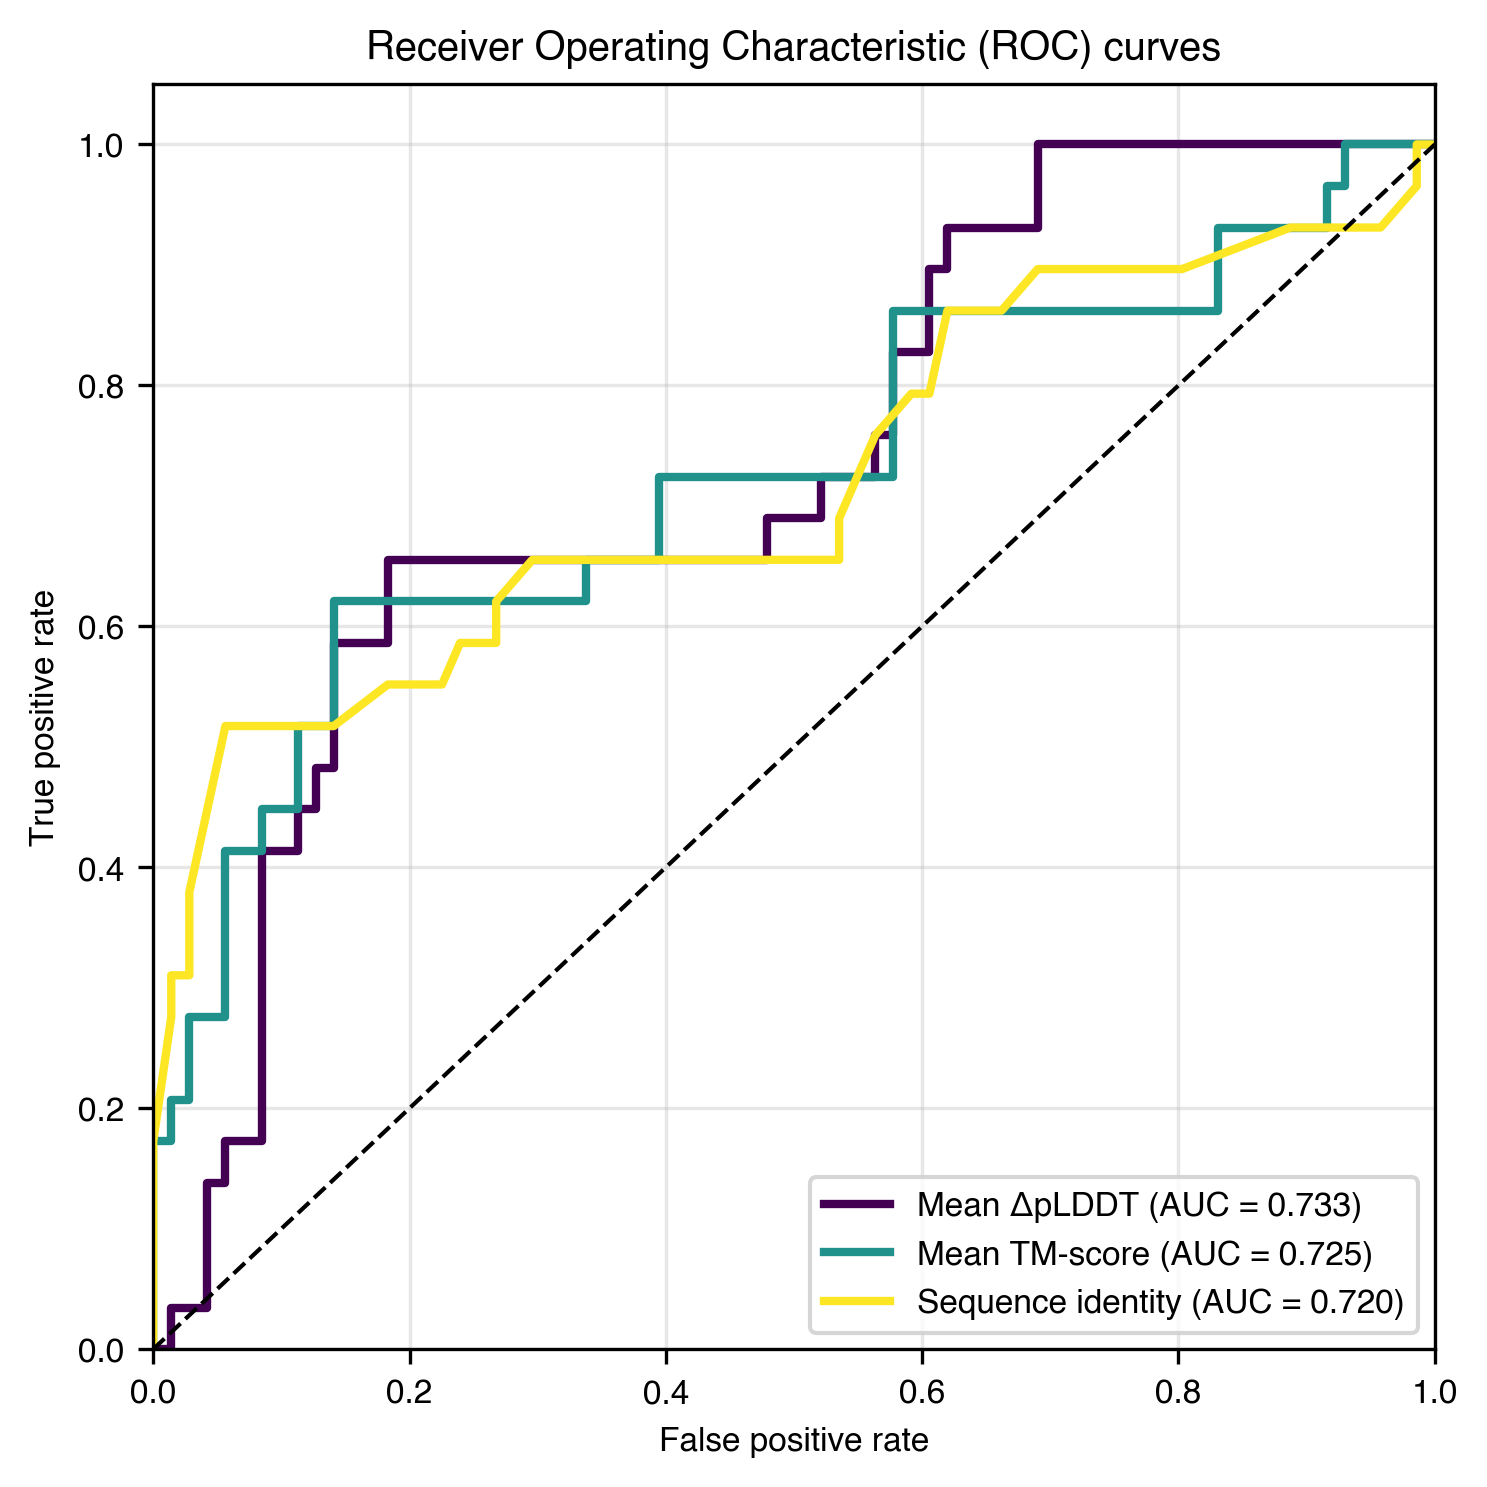

In [43]:
plot_corner_auroc(auroc, ['dplddt_mean', "tm_mean", "seqid"], 'active_x', figsize=(5, 5))